# K - Nearest Neighbour

## Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    roc_auc_score
)

import joblib
import os


## Load and Clean Dataset

#### Load the dataset (Before cleaning)

In [2]:
df = pd.read_csv('../../data/raw/FC212026_Malsha/Healthcare-Diabetes.csv')
df.head()

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


#### Drop ID column if it exists

In [3]:
if 'Id' in df.columns:
    df.drop('Id', axis=1, inplace=True)

#### Replace 0s with NaNs in non-logical columns

In [4]:
cols_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_to_fix] = df[cols_to_fix].replace(0, np.nan)

#### Fill missing values with median

In [5]:
df.fillna(df.median(numeric_only=True), inplace=True)

In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,126.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,126.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,126.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


### Feature & Target Split

In [7]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

### Normalize Features

In [8]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## Split Data -into Training and Testing Sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2768 non-null   int64  
 1   Glucose                   2768 non-null   float64
 2   BloodPressure             2768 non-null   float64
 3   SkinThickness             2768 non-null   float64
 4   Insulin                   2768 non-null   float64
 5   BMI                       2768 non-null   float64
 6   DiabetesPedigreeFunction  2768 non-null   float64
 7   Age                       2768 non-null   int64  
 8   Outcome                   2768 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 194.8 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000
mean,3.742775,121.863439,72.385838,29.205925,140.669798,32.593895,0.471193,33.132225,0.343931
std,3.323801,30.503499,11.988549,9.032220,82.887979,7.103462,0.325669,11.777230,0.475104
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,25.000000,120.000000,27.575000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,126.000000,32.400000,0.375000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.625000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,846.000000,80.600000,2.420000,81.000000,1.000000


In [11]:
df.to_csv('../../data/processed/FC212026_Malsha/Healthcare-Diabetes-Cleaned.csv', index=False)

## KNN with Hyperparameter Tuning

In [12]:
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

best_knn = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}


### Make Predictions

In [13]:
y_pred = best_knn.predict(X_test)
y_pred_prob = best_knn.predict_proba(X_test)[:, 1]

### Evaluation

In [14]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

Confusion Matrix:
 [[363   0]
 [  4 187]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       363
           1       1.00      0.98      0.99       191

    accuracy                           0.99       554
   macro avg       0.99      0.99      0.99       554
weighted avg       0.99      0.99      0.99       554

Accuracy Score: 0.9927797833935018
ROC AUC Score: 0.997194698051433


## Visualizations for Test Results

### Confusion Matrix Plot

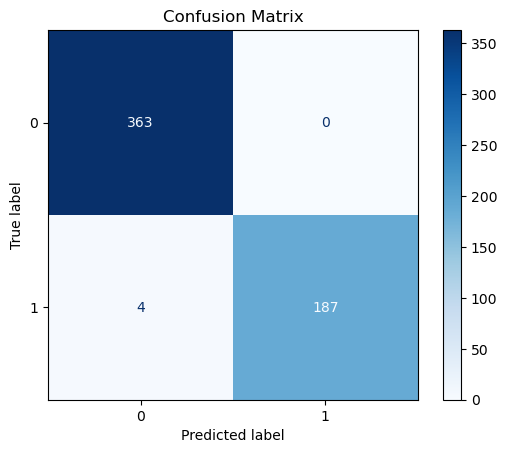

In [15]:
ConfusionMatrixDisplay.from_estimator(best_knn, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

### ROC Curve

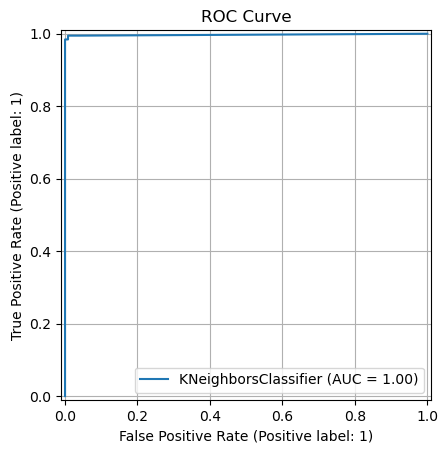

In [16]:
RocCurveDisplay.from_estimator(best_knn, X_test, y_test)
plt.title("ROC Curve")
plt.grid(True)
plt.show()

### Heatmap of Feature Correlation

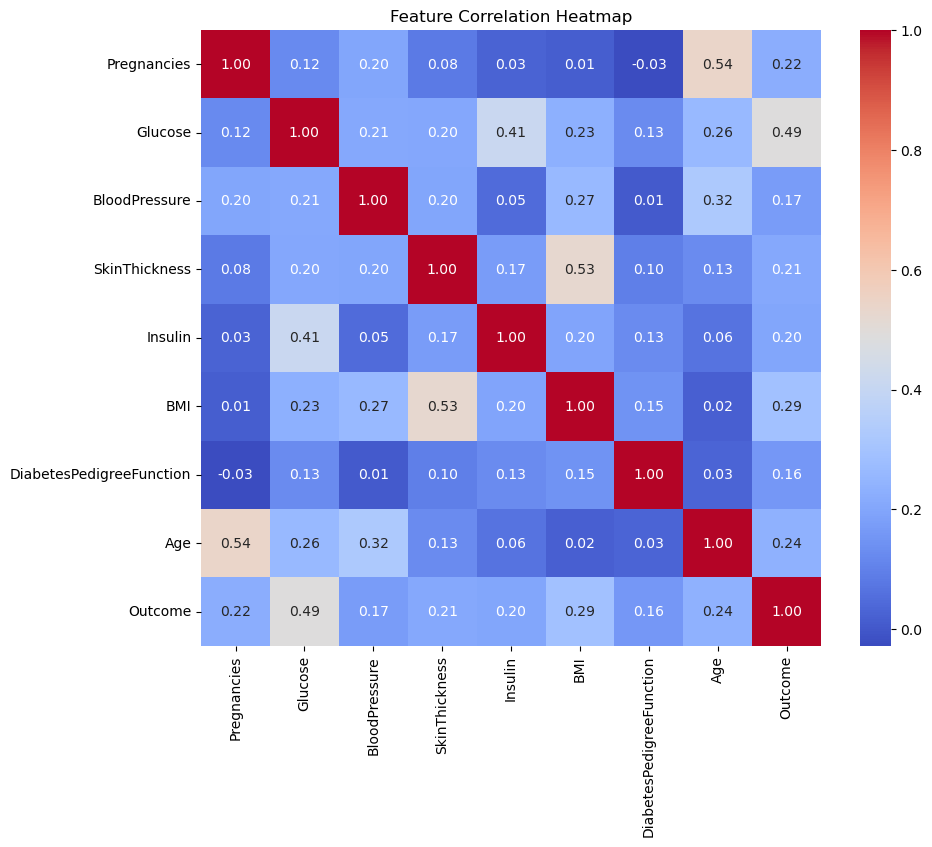

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

### Class Distribution in Test Set

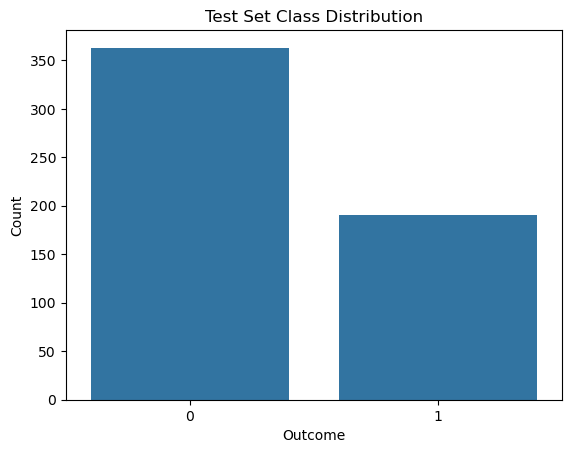

In [18]:
sns.countplot(x=y_test)
plt.title("Test Set Class Distribution")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.show()

In [19]:
os.makedirs('../../models', exist_ok=True)
joblib.dump(best_knn, '../../models/knn_best_model.pkl')
joblib.dump(scaler, '../../models/scaler_minmax.pkl')

['../../models/scaler_minmax.pkl']